In [1]:
# To help with reading and manipulation of data
import numpy as np
import pandas as pd
import pprint

# To help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To split the data
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

# to create k folds of data and get cross validation score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# to create pipeline and make_pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# to use standard scaler
from sklearn.preprocessing import StandardScaler

# To impute missing values
from sklearn.impute import SimpleImputer

# To build a Random forest classifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier

# To tune a model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# To get different performance metrics
import sklearn.metrics as metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
)

# To undersample and oversample the data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


# To suppress warnings
import warnings

In [97]:
data = pd.Series([1, 1, 6, 13, 13, 14, 14, 15, 15, 16, 18, 18, 18, 19, 100, 300], name="feature_1")
data2 = pd.Series([8, 60, 6, 13, 13, 14, 14, 15, 15, 16, 18, 18, 18, 19, 100, 300], name="feature_2")
target = pd.Series([1, 2, 5, 15, 13, 18, 14, 15, 14, 16, 18, 18, 18, 25, 30, 14], name="target")
main_data = pd.concat([data, data2, target], axis=1).reset_index()
main_data.drop("index", axis=1, inplace=True)

main_data

,feature_1,feature_2,target
0,1,8,1
1,1,60,2
2,6,6,5
3,13,13,15
4,13,13,13
5,14,14,18
6,14,14,14
7,15,15,15
8,15,15,14
9,16,16,16


In [101]:
import random
def addTwo(x):
    return x * random.randrange(20, 500, 3) * random.randrange(20, 500, 3)

main_data_copy = main_data.copy()
main_data_copy = main_data_copy.apply(addTwo)
corl = main_data_copy.corr().apply(addTwo)

corl.columns = corl.columns.str.replace('target', 'After')

df = pd.concat([main_data.corr()[['target']].apply(addTwo), corl[['After']]], axis=1)
sns.relplot(data=df, kind="line")

,target,After
feature_1,4317.792826,8541.529299
feature_2,2064.628388,4084.282080
target,22081.000000,43681.000000


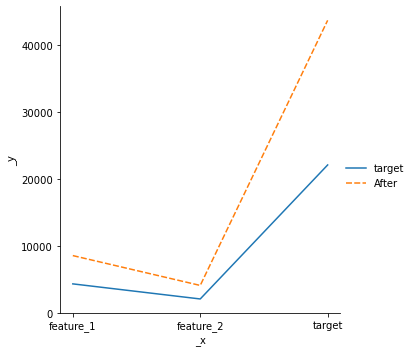

In [102]:
sns.relplot(data=df, kind="line")

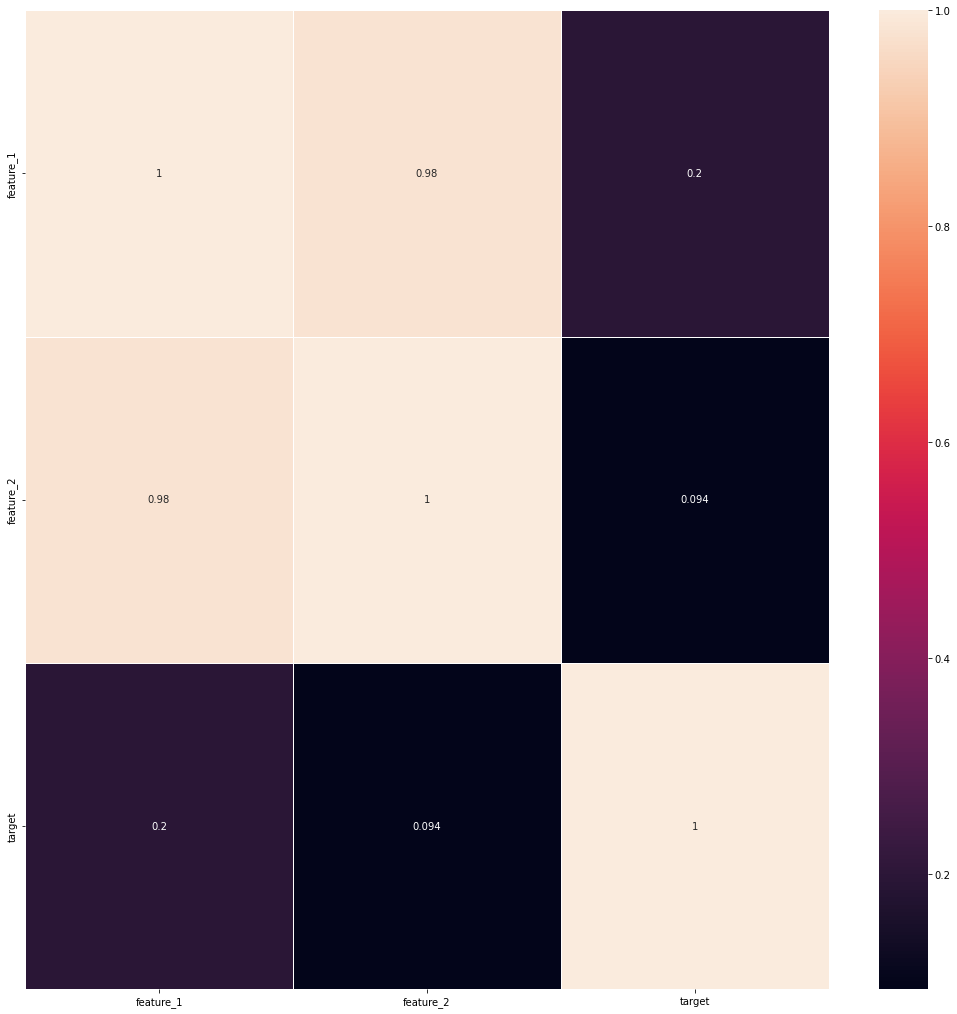

In [3]:
def corr():
    fig, ax = plt.subplots(figsize=(18,18)) 
    sns.heatmap(data=main_data.corr(), annot=True, linewidths=.5, ax=ax)
    plt.show()
corr()

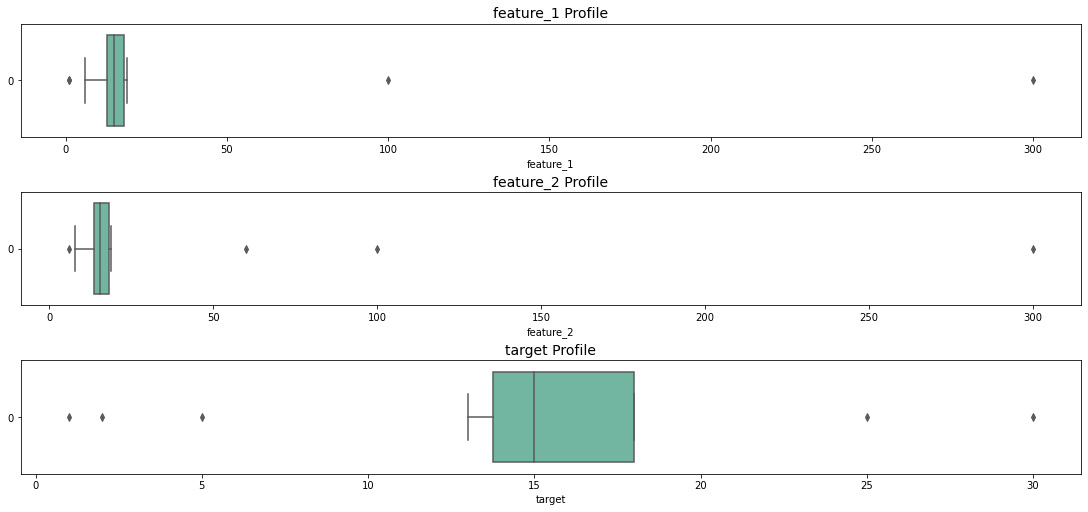

In [4]:
def PlotBoxes():
    columns = main_data.select_dtypes(include=['float', 'int64']).columns.tolist()
    fig, axs = plt.subplots(
        nrows=len(columns),
        ncols=1,                                                                # Number of columns of the grid.
        figsize=(15,7),                                                         # The size each figure
        constrained_layout=True)                                                # To avoid overlap between values
    
    count =0
    for ax in axs.flat:
        column_name = columns[count]
        ax = sns.boxplot(data=main_data[column_name], orient="h", palette="Set2", ax = ax)
        ax.set_xlabel(column_name)                                           
        ax.set_title(column_name + ' Profile', fontsize=14)
        count = count + 1
        
PlotBoxes()

In [5]:
def Get_IQR(data):
    quartiles = np.quantile(data, [.25, .75])
    iqr = (quartiles[1] - quartiles[0])
    print(f'Q1 = {quartiles[0]}, Q3 = {quartiles[1]}, IQR = {iqr}')
    return {
        "Q1": quartiles[0],
        "Q3": quartiles[1],
        "IQR": iqr
    }

In [6]:
def ReplaceOutlier(x, replacement_value, quatiles, scale):
    if x < quatiles["Q1"] - scale * quatiles["IQR"]  or x > quatiles["Q3"] + scale * quatiles["IQR"]:
        return replacement_value
    return x

In [7]:

def BestCorrOutlierTreatment(feature_column, target, df):
    max_corr = 0.0
    best_feature = df[feature_column]
    for r in range(10):
        main_data_copy = df.copy()
        main_data_copy[feature_column] = main_data_copy[feature_column].apply(
            ReplaceOutlier,
            convert_dtype     = True,
            replacement_value = main_data_copy[feature_column].median(),
            scale             = 4, 
            quatiles          = Get_IQR(main_data_copy[feature_column]))
        
        current_corr = main_data_copy.corr()[feature_column][target]
        print(f"IQR Scale: {r}, Scale Corrolation : {current_corr}")
        
        if current_corr > max_corr:
            max_corr = current_corr
            best_feature = main_data_copy[feature_column]
            
    return best_feature
        
main_data['feature_1'] = BestCorrOutlierTreatment('feature_1', 'target', main_data)
main_data['feature_2'] = BestCorrOutlierTreatment('feature_2', 'target', main_data)

Q1 = 13.0, Q3 = 18.0, IQR = 5.0
IQR Scale: 0, Scale Corrolation : 0.8442634687045236
Q1 = 13.0, Q3 = 18.0, IQR = 5.0
IQR Scale: 1, Scale Corrolation : 0.8442634687045236
Q1 = 13.0, Q3 = 18.0, IQR = 5.0
IQR Scale: 2, Scale Corrolation : 0.8442634687045236
Q1 = 13.0, Q3 = 18.0, IQR = 5.0
IQR Scale: 3, Scale Corrolation : 0.8442634687045236
Q1 = 13.0, Q3 = 18.0, IQR = 5.0
IQR Scale: 4, Scale Corrolation : 0.8442634687045236
Q1 = 13.0, Q3 = 18.0, IQR = 5.0
IQR Scale: 5, Scale Corrolation : 0.8442634687045236
Q1 = 13.0, Q3 = 18.0, IQR = 5.0
IQR Scale: 6, Scale Corrolation : 0.8442634687045236
Q1 = 13.0, Q3 = 18.0, IQR = 5.0
IQR Scale: 7, Scale Corrolation : 0.8442634687045236
Q1 = 13.0, Q3 = 18.0, IQR = 5.0
IQR Scale: 8, Scale Corrolation : 0.8442634687045236
Q1 = 13.0, Q3 = 18.0, IQR = 5.0
IQR Scale: 9, Scale Corrolation : 0.8442634687045236
Q1 = 13.75, Q3 = 18.25, IQR = 4.5
IQR Scale: 0, Scale Corrolation : 0.6595279218008461
Q1 = 13.75, Q3 = 18.25, IQR = 4.5
IQR Scale: 1, Scale Corrolati

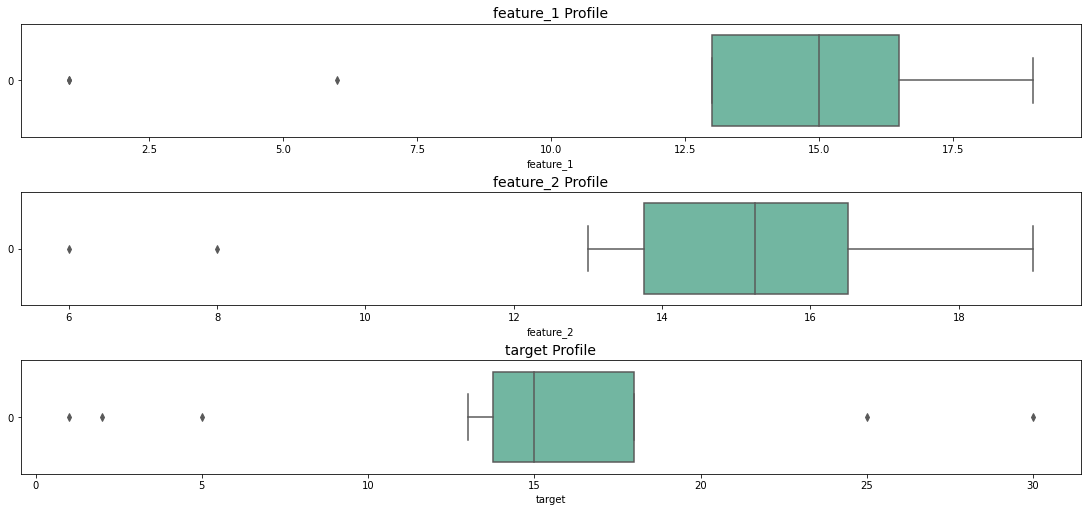

In [8]:
PlotBoxes()

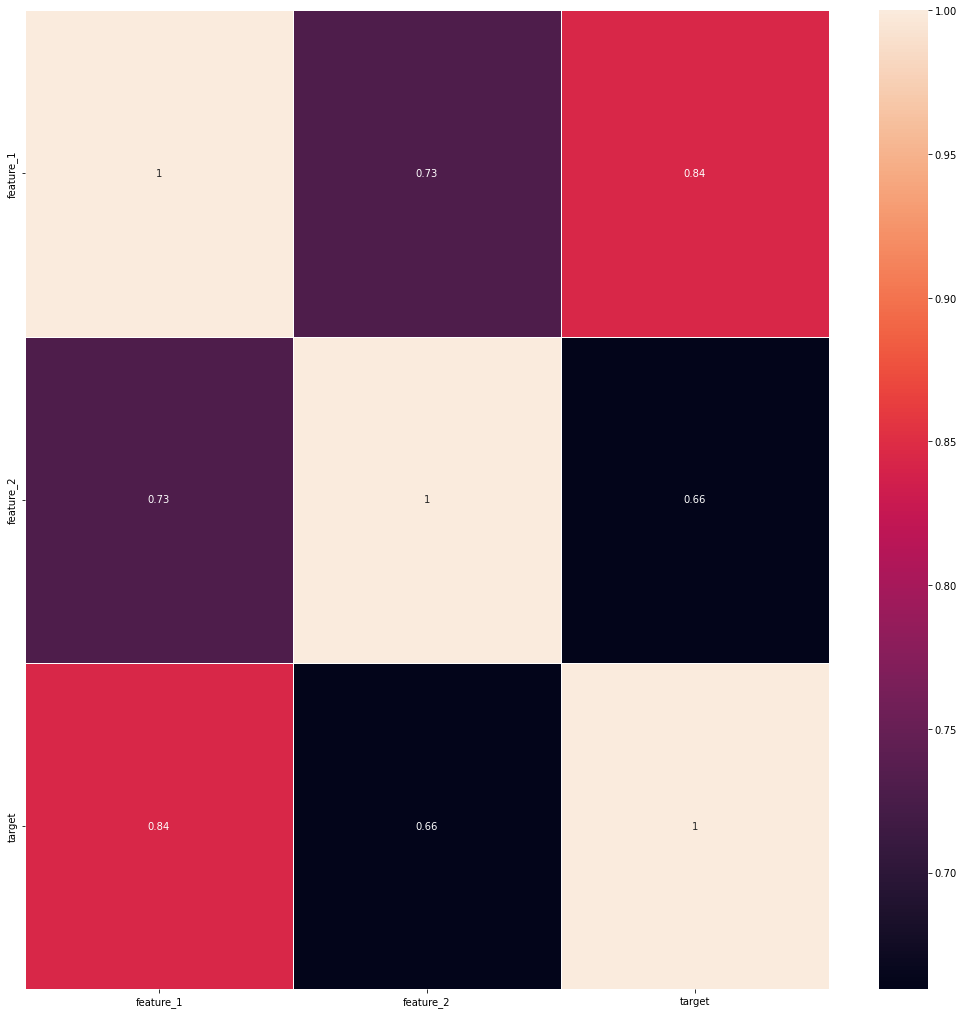

In [9]:
corr()

In [10]:
main_data.head(20)

,feature_1,feature_2,target
0,1.0,8.0,1
1,1.0,15.5,2
2,6.0,6.0,5
3,13.0,13.0,15
4,13.0,13.0,13
5,14.0,14.0,18
6,14.0,14.0,14
7,15.0,15.0,15
8,15.0,15.0,14
9,16.0,16.0,16
